In [2]:
#converts input image to ela applied image
from PIL import Image, ImageChops, ImageEnhance


def convert_to_ela_image(filename,quality):

    Original_Image = Image.open(filename).convert('RGB')

    Compressed_Image_filename = 'resaved_image.jpg'
    Original_Image.save(Compressed_Image_filename,'JPEG',quality=quality)
    Compressed_Image = Image.open(Compressed_Image_filename)

    ELA_Image = ImageChops.difference(Original_Image,Compressed_Image)
    
    #scaling factors are calculated from pixel extremas
    extrema = ELA_Image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 350.0 / max_difference
    
    ELA_Image = ImageEnhance.Brightness(ELA_Image).enhance(scale)

    ELA_Image.save("ela_image.png")
    return ELA_Image

In [3]:
from os import listdir
from os.path import isfile

import numpy as np

def PreProcess(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize((128, 128))).flatten() / 255.0

def getDataSet(DataSetType):
    X = [] # Images
    Y = [] # 0 = fake, 1 = real

    if(DataSetType == 0):
        TestOrTrain = 'archive/train'
    else:
        TestOrTrain = 'archive/test'

    path = TestOrTrain+'/REAL'
    print(path);

    allFiles = []
    for f in listdir(path):
        if(isfile(path + '/'+ f)):
            allFiles.append(path + '/'+ f);
    
    for file in allFiles:
        if file.endswith('jpg') or file.endswith('png'):
            X.append(PreProcess(file))        
            Y.append(1)     # label for authentic images 
            
    print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')


    path = TestOrTrain+'/FAKE'
    print(path);

    allFiles = []
    for f in listdir(path):
        if(isfile(path + '/'+ f)):
            allFiles.append(path + '/'+ f);
    
    for file in allFiles:
        if file.endswith('jpg') or file.endswith('png'):
            X.append(PreProcess(file))        
            Y.append(0)     # label for authentic images 
            
    print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(-1, 128, 128, 3)

    return X, Y

In [1]:

import tensorflow as tf

# Display the version
print(tf.__version__)

# other imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,Activation,Conv2D, Conv2DTranspose, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from tensorflow.keras import layers
from tensorflow.python.keras.utils.np_utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2.10.0


In [5]:
test_X, test_Y = getDataSet(1);

archive/test/REAL
Total images: 10000
Total labels: 10000
archive/test/FAKE
Total images: 20000
Total labels: 20000


In [2]:

test_X = np.load("testDatasetX.npy")
test_Y = np.load("testDatasetY.npy")



In [3]:

X_Train, X_Test, Y_Train, Y_Test = train_test_split(test_X, test_Y, test_size = 0.2, random_state=5) 

In [7]:

model = Sequential()

model.add(Input(shape=(128, 128, 3)))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='valid', strides=(1, 1)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid', strides=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid', strides=(1, 1)))


model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='valid', strides=(1, 1)))
model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), activation='relu', padding='valid', strides=(1, 1)))


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 124, 124, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 126, 126, 32)     18464     
 ranspose)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 508032)           

In [8]:

r = model.fit(X_Train, Y_Train, epochs=10, batch_size=256,validation_split=0.2)

Epoch 1/10
50/50 [==============================] - 237s 4s/step - loss: 0.6446 - accuracy: 0.6714 - val_loss: 0.4995 - val_accuracy: 0.7588
Epoch 2/10
50/50 [==============================] - 220s 4s/step - loss: 0.4893 - accuracy: 0.7650 - val_loss: 0.4667 - val_accuracy: 0.7919
Epoch 3/10
50/50 [==============================] - 218s 4s/step - loss: 0.4541 - accuracy: 0.7877 - val_loss: 0.4657 - val_accuracy: 0.7856
Epoch 4/10
50/50 [==============================] - 216s 4s/step - loss: 0.4386 - accuracy: 0.7954 - val_loss: 0.4466 - val_accuracy: 0.7962
Epoch 5/10
50/50 [==============================] - 216s 4s/step - loss: 0.4040 - accuracy: 0.8138 - val_loss: 0.4524 - val_accuracy: 0.7875
Epoch 6/10
50/50 [==============================] - 218s 4s/step - loss: 0.3846 - accuracy: 0.8270 - val_loss: 0.4673 - val_accuracy: 0.7897
Epoch 7/10
50/50 [==============================] - 211s 4s/step - loss: 0.3349 - accuracy: 0.8552 - val_loss: 0.4761 - val_accuracy: 0.7916
Epoch 8/10
50

In [9]:
model.save('my_model.keras')

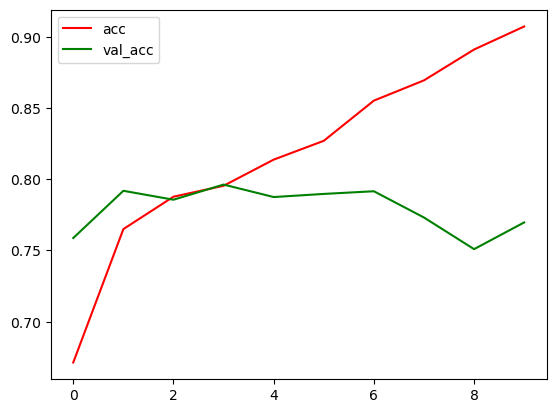

In [10]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()
#pd.DataFrame(history.history).plot()

In [11]:
new_model = tf.keras.models.load_model('my_model.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 124, 124, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 126, 126, 32)     18464     
 ranspose)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 508032)           

In [ ]:
test_case = convert_to_ela_image("insert image here.")
test_case = np.reshape(test_case, (1, 128, 128, 3))
prediction = new_model.predict(test_case)

print("Prediction:", prediction)